In [1]:

import pandas as pd
import logging
import numpy as np
import sys
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from random import shuffle
from sklearn.base import BaseEstimator, RegressorMixin
from scipy.optimize import minimize
from sklearn.model_selection import GridSearchCV, PredefinedSplit
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error, make_scorer

from datetime import date
from datetime import time
from datetime import datetime
from datetime import timedelta
%matplotlib inline


from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
#PLOT CONFUSION MATRIX
from sklearn.metrics import confusion_matrix
import itertools

#matrix inverse
from numpy.linalg import inv

#see the value of multiple statements at once
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

#retina resolution figure
%config InlineBackend.figure_format = 'retina'

#default size of the graph
plt.rcParams['figure.figsize'] = (10.0, 8.0) 

%load_ext autoreload
%autoreload 2

/Users/hp/anaconda/lib/python3.5/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
col_rs = 'region_start_time'
col_es = 'episode_starts'
col_le = 'long_episodes'

In [3]:
np.mean
### shift + tab

<function numpy.core.fromnumeric.mean>

In [4]:
def filtertime(dat, start_date, end_date):
    return np.array(start_date <= dat[col_rs]) & \
         np.array(dat[col_rs] <= end_date)

In [5]:
def addepoch(dat, start, end, num_per_epoch):
    
    c = end - start
    num_epoch  = int(np.floor(c.days/num_per_epoch))
    start_dates = [start + timedelta(days = i * num_per_epoch) for i in range(num_epoch)]
    end_dates = [start + timedelta(days = (i + 1) * num_per_epoch) for i in range(num_epoch)]
    dates = list(zip(start_dates, end_dates))
    end = dates[-1][-1]
    for i in range(num_epoch):
        date_tup = dates[i]
        dstart, dend = date_tup[0],date_tup[1]
        dat.loc[filtertime(dat, dstart, dend),'epoch'] = int(i)
    data = dat[np.array(start <= dat.loc[:,col_rs]) & \
         np.array(dat.loc[:,col_rs] <= end)]
    data.loc[:,'epoch'] = data.loc[:,'epoch'].astype(int)
    return data

In [6]:
def firstnorm(dat, col):
    base = np.array(dat.loc[:,col])[0]
    dat.loc[:,col] = dat.loc[:,col] / base
    return dat, base

In [7]:
def dat_agg(dat):
    N = dat.shape[0]
    dat_epi_agg = dat.loc[:, [col_es, 'epoch']].groupby('epoch').agg('mean')
    dat_epi_agg, base_epi = firstnorm(dat_epi_agg, col_es)
    dat_le_agg = dat.loc[:, [col_le, 'epoch']].groupby('epoch').agg('mean')
    dat_le_agg, base_le = firstnorm(dat_le_agg, col_le)
    dat_epi_agg_ste = dat.loc[:, [col_es, 'epoch']].groupby('epoch').std()/base_epi/np.sqrt(N)
    dat_le_agg_ste = dat.loc[:, [col_le, 'epoch']].groupby('epoch').std()/base_le/np.sqrt(N)
    
    return dat_epi_agg, dat_le_agg, dat_epi_agg_ste, dat_le_agg_ste

In [8]:
def epoch_label(dat_tup, col_metric):
    if col_metric != col_es and col_metric != col_le:
        sys.exit('col_metric wrong')
    dat = dat_tup[0]
    dat_epi_agg, dat_le_agg, dat_epi_agg_ste, dat_le_agg_ste = dat_agg(dat)
    if col_metric == col_es:
        n = dat_epi_agg.shape[0]
        thres = np.median(dat_epi_agg)
        keys = list(np.array(dat_epi_agg.index, dtype = int))
        vals = list(np.array(dat_epi_agg.loc[:,col_metric] < thres))
    elif col_metric == col_le:
        n = dat_le_agg.shape[0]
        thres = np.median(dat_le_agg)
        keys = list(np.array(dat_le_agg.index, dtype = int))
        vals = list(np.array(dat_le_agg.loc[:,col_metric] < thres))
    epoch_label = dict(zip(keys, vals))
    for key in epoch_label:
        val = epoch_label[key]
        dat.loc[dat['epoch'] == key,'label'] = val
    data = (dat, dat_tup[1])
    return data, epoch_label

In [9]:
def prep(dat, start, end, num_per_epoch, patid):
    dat.loc[:,col_rs] = pd.to_datetime(dat.loc[:,col_rs])
    data_1 = addepoch(dat, start, end, num_per_epoch)
    cache = [start, end, num_per_epoch, patid]
    data_2 = (data_1, cache)
    data_3_es, epoch_label_dict_es = epoch_label(data_2, col_es)
    data_3_le, epoch_label_dict_le = epoch_label(data_2, col_le)
    return data_3_es, epoch_label_dict_es, data_3_le, epoch_label_dict_le

In [10]:
def plot_epoch_mean(dat_tup):
    dat = dat_tup[0]
    ptid = dat_tup[1][3]
    period_start = str(dat_tup[1][0])[:10]
    period_end = str(dat_tup[1][1])[:10]
    
    dat_epi_agg, dat_le_agg, dat_epi_agg_ste, dat_le_agg_ste = dat_agg(dat)
    plt.figure()
    plt.plot(dat_epi_agg, label = 'episodes start mean')
    plt.plot(dat_epi_agg + dat_epi_agg_ste,linestyle='dashed', label = 'episodes start mean + sem')
    plt.plot(dat_epi_agg - dat_epi_agg_ste,linestyle='dashed', label = 'episodes start mean - sem')
    plt.plot(dat_le_agg, label = 'long episode mean')
    plt.plot(dat_le_agg + dat_le_agg_ste,linestyle='dashed', label = 'long episode mean + sem')
    plt.plot(dat_le_agg - dat_le_agg_ste,linestyle='dashed', label = 'long episode mean - sem')
    plt.title('Patient {0}: period {1} - {2}'.format(ptid, period_start, period_end))
    plt.xlabel('epoch')
    plt.ylabel('count(nomalized)')
    plt.tight_layout()
    plt.legend()
    plt.show()


In [11]:
start_222_1 = datetime.strptime('Feb 12 2016', '%b %d %Y')
end_222_1 = datetime.strptime('Oct 24 2016', '%b %d %Y')
num_per_epoch_222_1 = 31

start_222_2 = datetime.strptime('Oct 26 2016', '%b %d %Y')
end_222_2 = datetime.strptime('May 29 2017', '%b %d %Y')
num_per_epoch_222_2 = 30

start_222_3 = datetime.strptime('Sep 19 2017', '%b %d %Y')
end_222_3 = datetime.strptime('Jan 30 2018', '%b %d %Y')
num_per_epoch_222_3 = 31


start_231 = datetime.strptime('Feb 7 2017', '%b %d %Y')
end_231 = datetime.strptime('Feb 21 2018', '%b %d %Y')
num_per_epoch_231 = 31

In [12]:
raw_data_222 = pd.read_csv('../data/NY222_2015-08-11_to_2018-06-12_daily_20180613153105.csv', skiprows = 3)
raw_data_231 = pd.read_csv('../data/NY231_2016-07-05_to_2018-06-12_daily_20180613153815.csv', skiprows = 3)

In [13]:
data_222_1_es, epoch_label_222_1_es, data_222_1_le, epoch_label_222_1_le = prep(raw_data_222, start_222_1, end_222_1, num_per_epoch_222_1, 222)
data_222_2_es, epoch_label_222_2_es, data_222_2_le, epoch_label_222_2_le = prep(raw_data_222, start_222_2, end_222_2, num_per_epoch_222_2, 222)
data_222_3_es, epoch_label_222_3_es, data_222_3_le, epoch_label_222_3_le = prep(raw_data_222, start_222_3, end_222_3, num_per_epoch_222_3, 222)
data_231_es, epoch_label_231_es, data_231_le, epoch_label_231_le = prep(raw_data_231, start_231, end_231, num_per_epoch_231, 231)


/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


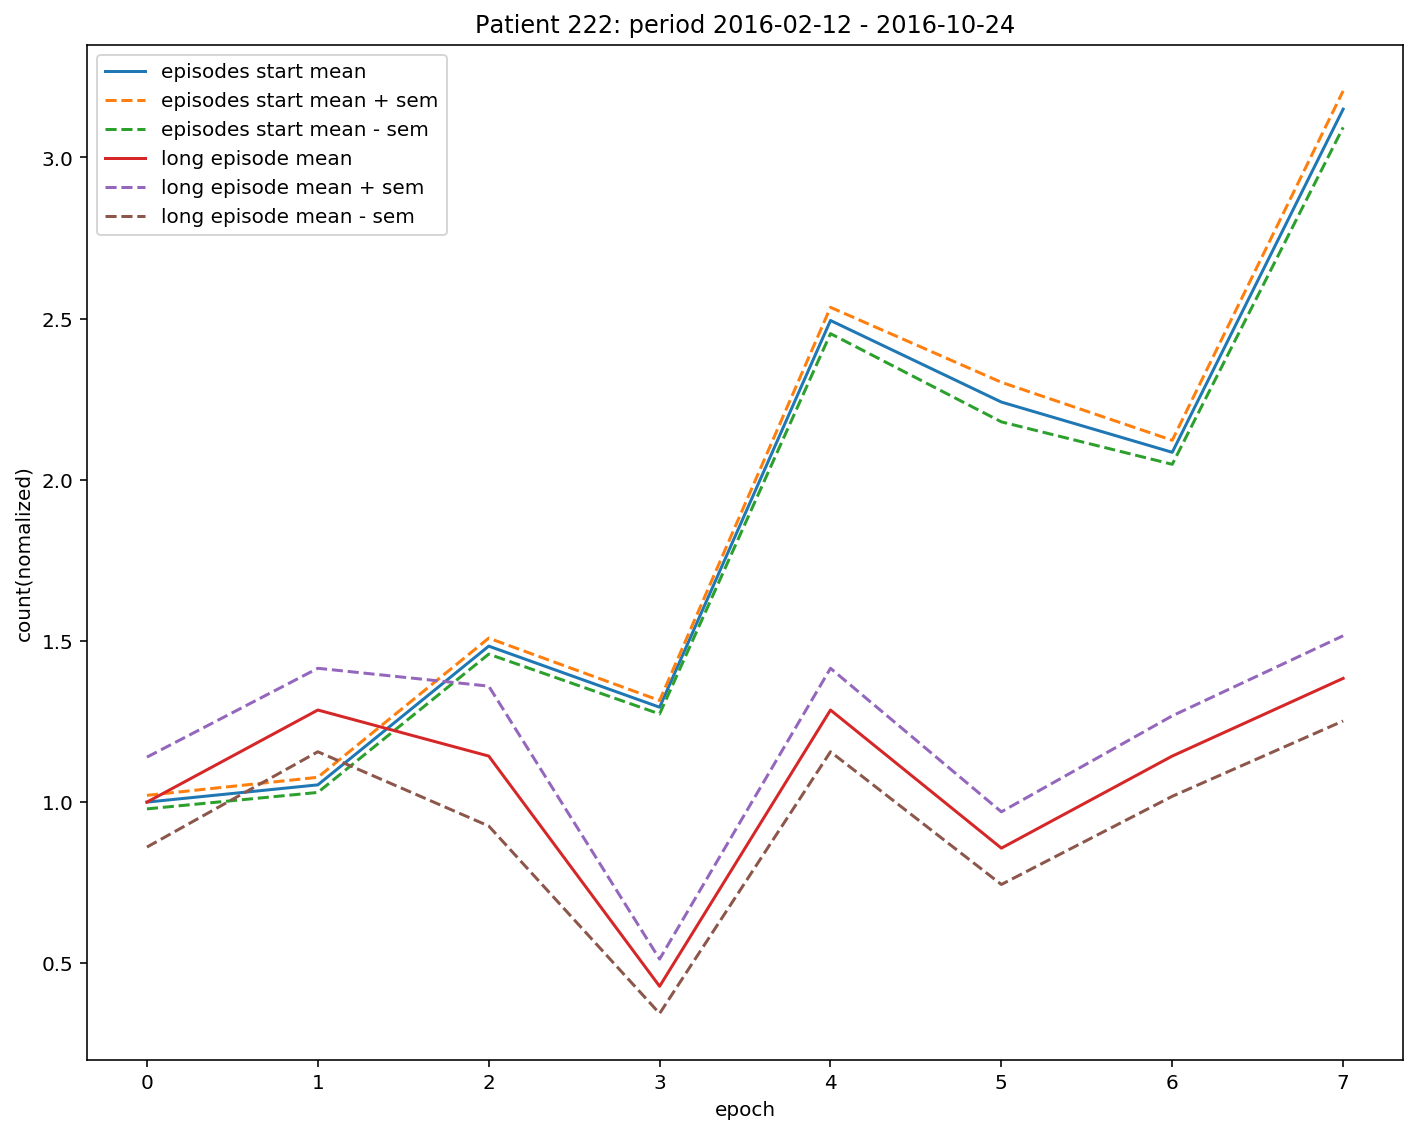

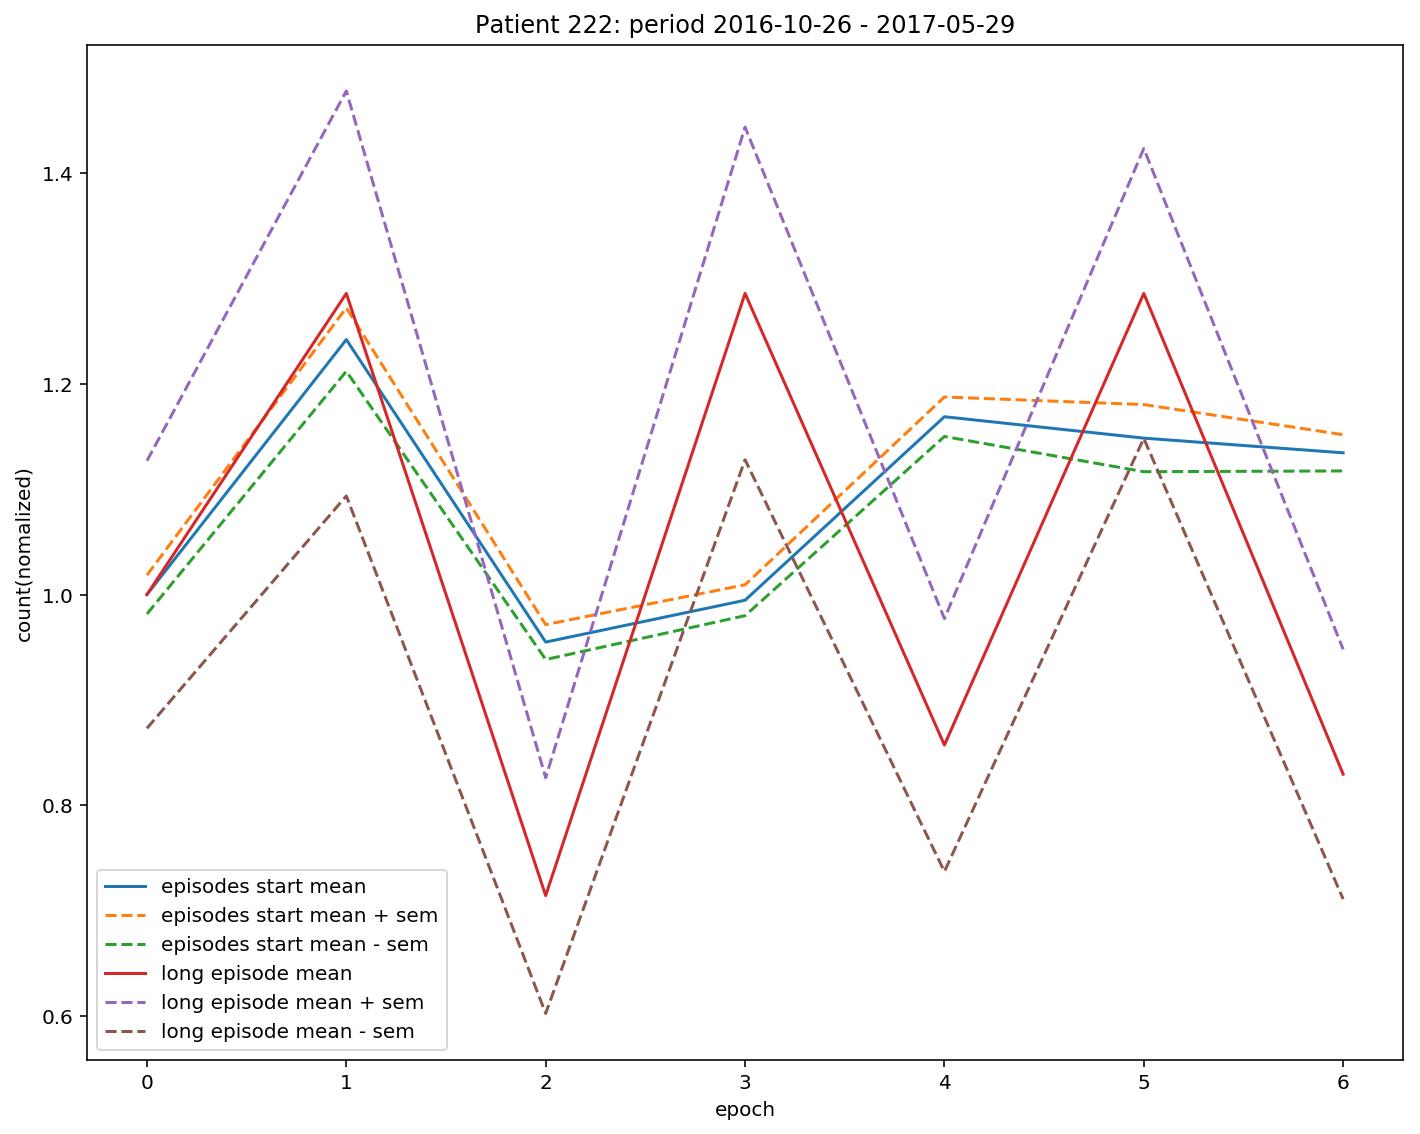

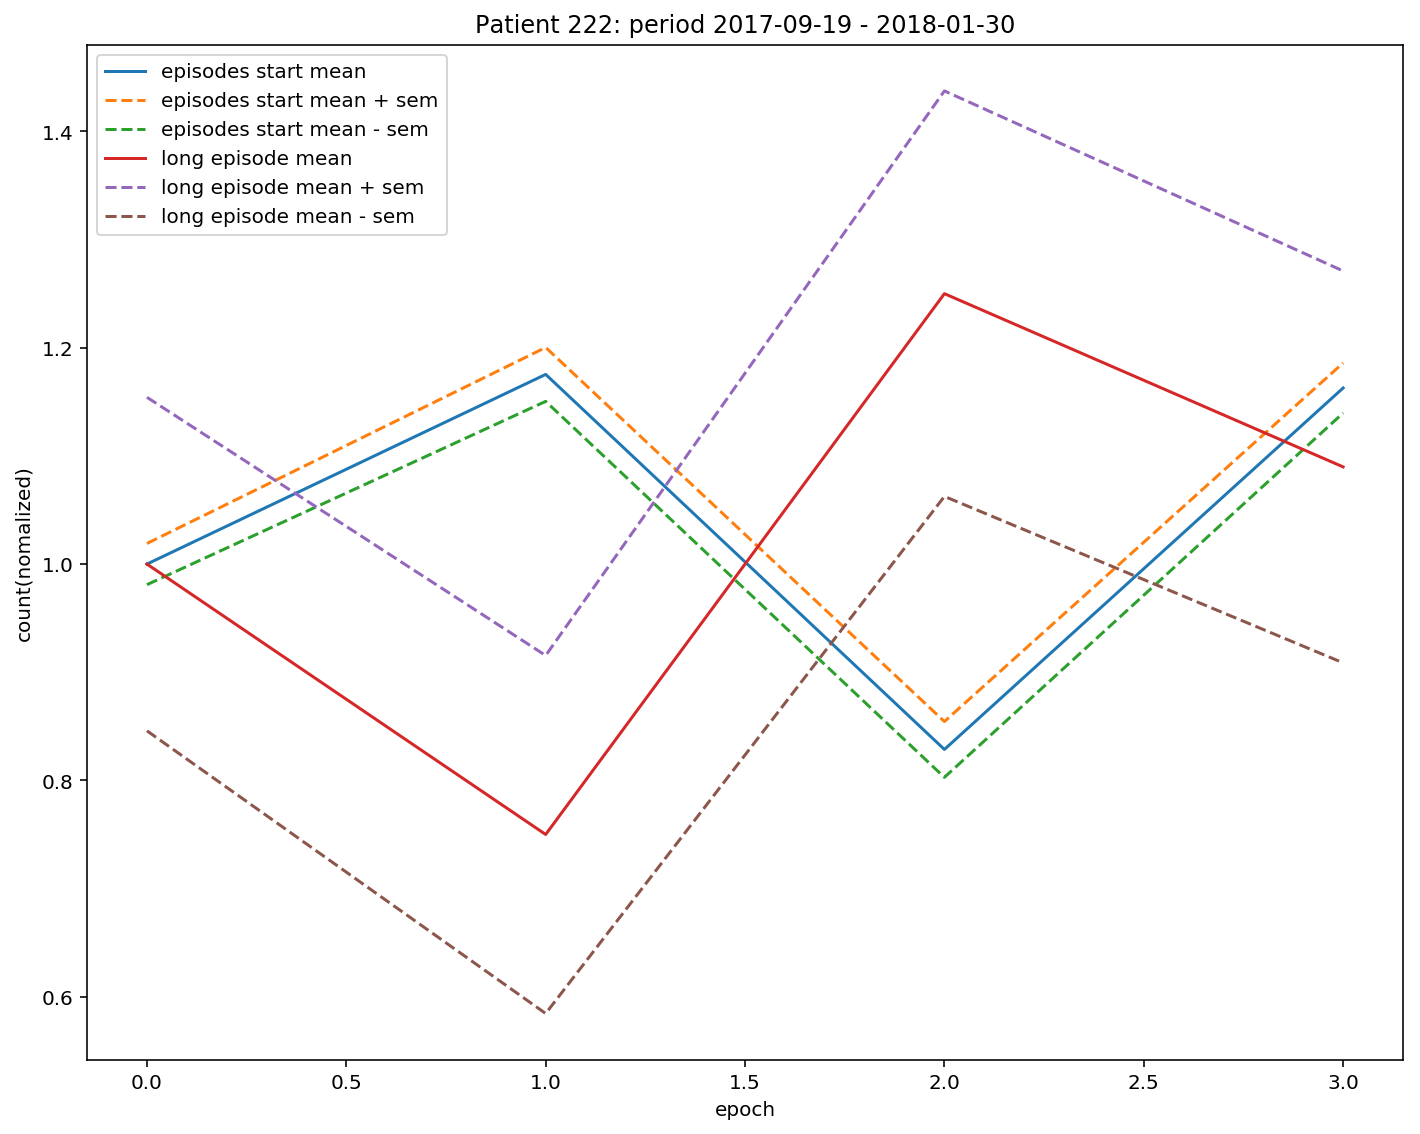

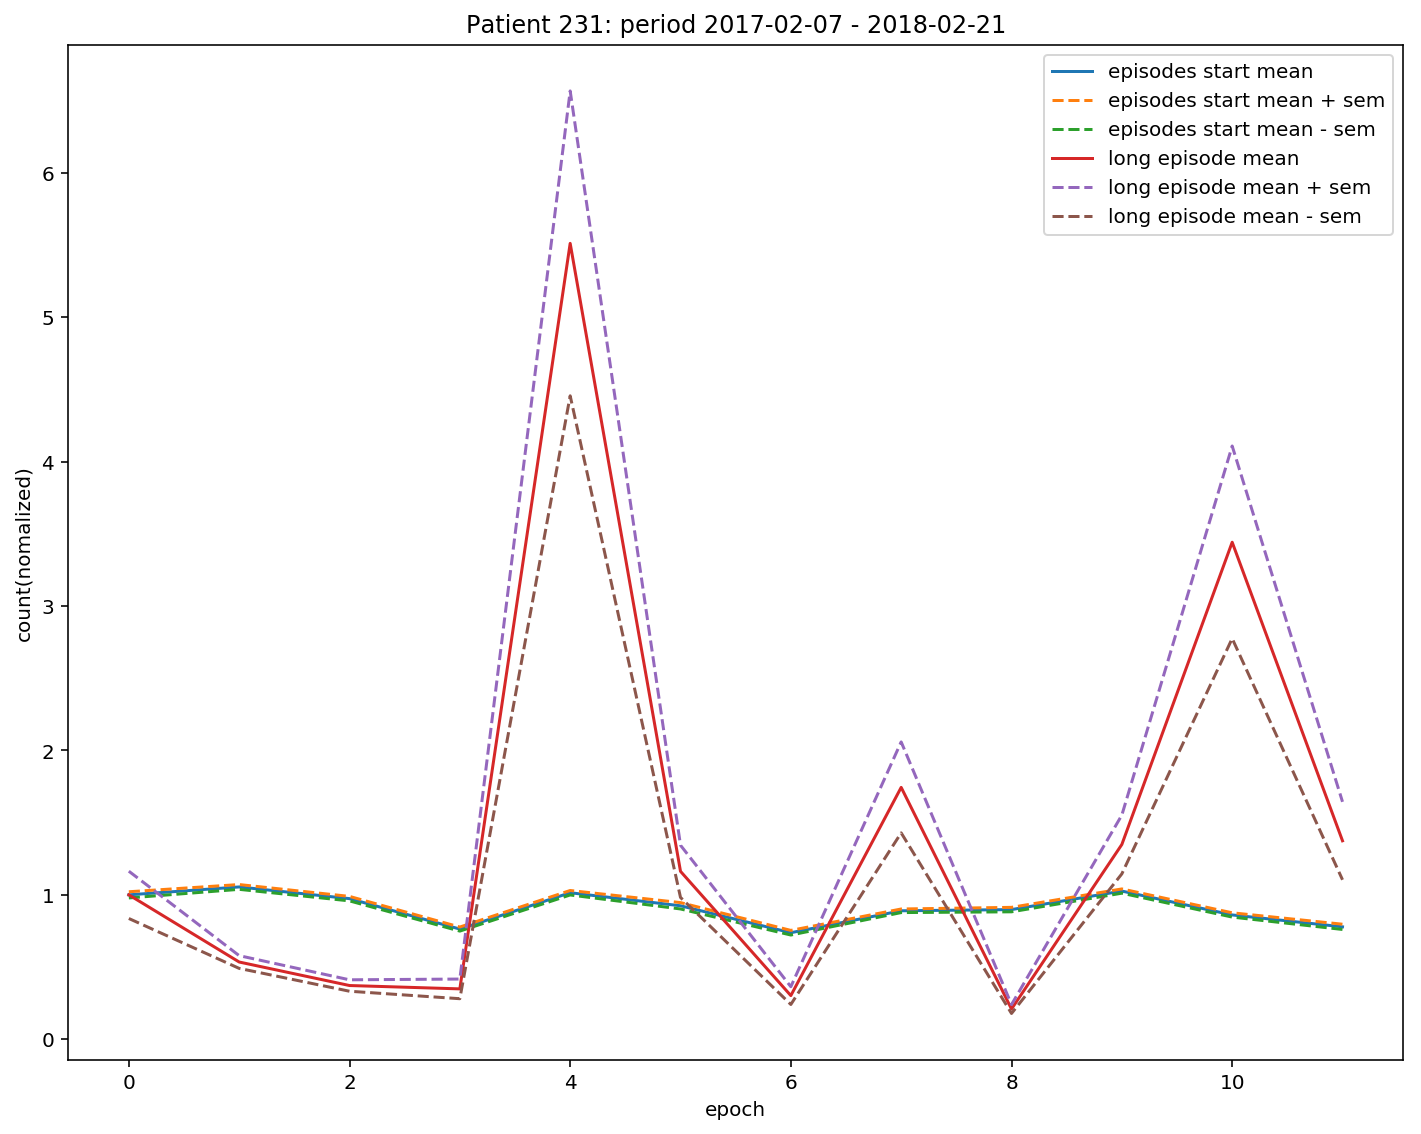

In [14]:
plot_epoch_mean(data_222_1_es)
plot_epoch_mean(data_222_2_es)
plot_epoch_mean(data_222_3_es)
plot_epoch_mean(data_231_es)

In [15]:
import h5py

def read_features(f):
    powbands = ['delta', 'theta', 'alpha', 'beta', 'low_gamma', 'high_gamma', 'all']
    col_names = [col_rs]
    for powband in powbands:
        for i in range(1,5):
            col_names.append(powband+str(i))
    col_names.append('i12')
    col_names.append('i34')
    features_222 = np.array(f['T_222_arr_scheduled']).T
    features_231 = np.array(f['T_231_arr_scheduled']).T
    features_df_222 = pd.DataFrame(features_222, columns = col_names)
    features_df_231 = pd.DataFrame(features_231, columns = col_names)
    features_df_222.loc[:,col_rs] = pd.to_datetime(features_df_222.loc[:,col_rs], unit = 'd', origin=pd.Timestamp('2000-01-01'))
    features_df_231.loc[:,col_rs] = pd.to_datetime(features_df_231.loc[:,col_rs], unit = 'd', origin=pd.Timestamp('2000-01-01'))
    return features_df_222, features_df_231

In [16]:
def feature_label(features, start, end, num_per_epoch, epoch_label_dict):
    features_epoch = addepoch(features, start, end, num_per_epoch)
    for key in epoch_label_dict:
        val = epoch_label_dict[key]
        features_epoch.loc[features_epoch.loc[:,'epoch'] == key,'label'] = val
    return features_epoch

In [17]:
def add_id(df, pat_id, if_stimulated):
    df.loc[:,'patid'] = pat_id
    df.loc[:,'if_stimulated'] = if_stimulated
    return df

In [18]:
f = h5py.File('../data/features.mat', 'r')
f_s = h5py.File('../data/features_sti.mat', 'r')

In [19]:

fea_222, fea_231 = read_features(f)
fea_222_s, fea_231_s = read_features(f_s)
feature_label_222_1 = add_id(feature_label(fea_222, start_222_1, end_222_1, num_per_epoch_222_1, epoch_label_222_1_le), '222_1', False)
feature_label_222_2 = add_id(feature_label(fea_222, start_222_2, end_222_2, num_per_epoch_222_2, epoch_label_222_2_le), '222_2', False)
feature_label_222_3 = add_id(feature_label(fea_222, start_222_3, end_222_3, num_per_epoch_222_3, epoch_label_222_3_le), '222_3', False)
feature_label_231= add_id(feature_label(fea_231, start_231, end_231, num_per_epoch_231, epoch_label_231_le) , '231', False)
feature_label_222_1_s = add_id(feature_label(fea_222_s, start_222_1, end_222_1, num_per_epoch_222_1, epoch_label_222_1_le), '222_1', True)
feature_label_222_2_s = add_id(feature_label(fea_222_s, start_222_2, end_222_2, num_per_epoch_222_2, epoch_label_222_2_le), '222_2', True)
feature_label_222_3_s = add_id(feature_label(fea_222_s, start_222_3, end_222_3, num_per_epoch_222_3, epoch_label_222_3_le), '222_3', True)
feature_label_231_s = add_id(feature_label(fea_231_s, start_231, end_231, num_per_epoch_231, epoch_label_231_le) , '231', True) 

/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/Users/hp/anaconda/lib/python3.5/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)


In [20]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 500)
data = pd.concat([feature_label_222_1, feature_label_222_2, feature_label_222_3, feature_label_231, feature_label_222_1_s, feature_label_222_2_s, feature_label_222_3_s, feature_label_231_s], axis = 0)
data
data.to_pickle('../data/ml_ready_data.p')

,region_start_time,delta1,delta2,delta3,delta4,theta1,theta2,theta3,theta4,alpha1,alpha2,alpha3,alpha4,beta1,beta2,beta3,beta4,low_gamma1,low_gamma2,low_gamma3,low_gamma4,high_gamma1,high_gamma2,high_gamma3,high_gamma4,all1,all2,all3,all4,i12,i34,epoch,label,patid,if_stimulated
86,2016-02-14 03:59:36.960000000,61.166777,273.677292,33.567358,81.248637,67.960011,407.512272,63.612452,165.585550,33.925524,162.907198,57.022700,124.072916,49.942659,210.731685,98.466079,165.458683,18.695004,103.421166,105.274561,112.045059,16.015592,35.626594,48.474736,42.528788,270505.648416,270925.959139,270450.109364,270548.335292,0.0,0.0,0,True,222_1,False
87,2016-02-15 20:59:18.960000000,40.548970,773.155098,25.976910,93.999419,88.948090,503.859680,73.651095,197.519216,39.238212,112.808047,86.997672,128.031086,52.873261,138.517794,152.987582,171.241961,14.265443,65.359496,72.104178,96.212837,15.319884,27.377590,33.609060,41.340546,270541.852308,271395.501016,270500.754589,270572.237156,0.0,0.0,0,True,222_1,False
88,2016-02-16 20:59:12.998400000,41.771440,172.179804,32.841169,87.193198,80.706647,365.497322,85.883900,207.473196,33.080845,94.292694,75.533254,123.768713,56.404587,143.718022,118.482315,178.673804,14.339917,69.583152,72.095121,100.593240,15.511631,28.402951,44.420213,42.202363,270486.069868,270643.939073,270513.407086,270595.565029,0.0,0.0,0,True,222_1,False
89,2016-02-18 03:58:56.006400000,42.171885,290.146548,36.623014,105.840151,63.743945,355.238470,74.584256,193.461227,30.871455,144.966682,72.422374,116.980173,45.148116,206.176548,108.270834,163.863623,16.005505,93.627380,76.516633,92.099606,15.886343,34.121157,39.598289,37.980698,270552.083287,270996.255023,270528.892589,270593.094945,0.0,0.0,0,True,222_1,False
90,2016-02-19 03:58:42.960000000,45.669290,290.906726,25.191820,97.232432,86.755984,408.625743,64.573149,182.458501,36.730032,156.588716,62.576354,139.567459,40.670068,208.031761,100.449275,162.223919,14.537095,94.498731,69.536017,87.049100,15.697947,32.902126,34.724215,39.093305,270504.954508,270973.849448,270490.633051,270673.911224,0.0,0.0,0,True,222_1,False
91,2016-02-25 20:57:42.019200000,40.690762,143.452769,20.017652,84.349656,70.185465,298.778963,63.712581,187.682257,40.480499,124.879448,90.047558,158.766110,69.582234,138.830090,175.467275,241.053966,15.364279,74.841248,61.701677,99.329107,15.691182,31.262835,27.282511,45.456615,270549.377107,270611.236250,270522.326050,270590.438455,0.0,0.0,0,True,222_1,False
92,2016-02-27 03:57:25.027200000,46.372224,197.027519,59.479690,142.762268,70.416304,267.841576,119.720889,228.432295,92.206276,168.611750,72.740025,139.582448,51.747494,206.568610,157.475100,165.038254,12.468371,77.860935,58.551378,67.348458,14.885366,27.811003,35.298766,32.740643,270639.369591,270657.083536,270555.228088,270598.438945,0.0,0.0,0,True,222_1,False
93,2016-02-27 15:57:23.040000000,48.966374,181.547345,28.612515,84.556678,86.080660,353.788040,85.700540,241.125144,40.860754,138.565280,81.331796,158.148734,60.727009,129.556731,120.082370,177.946510,15.221299,70.128487,55.009903,81.472875,15.977915,30.501644,28.431565,35.663815,270700.281764,270717.389422,270536.210576,270773.112281,0.0,0.0,0,True,222_1,False
94,2016-03-02 03:56:47.011200000,37.949517,177.184674,25.164441,114.003293,60.099358,247.724630,86.791744,205.304044,33.358201,117.547139,127.287526,158.071696,50.568384,166.873544,159.130591,182.808226,13.655150,78.657507,44.672032,72.206554,14.889559,31.338755,22.642040,37.287734,270589.495356,270654.298186,270537.205138,270760.501198,0.0,0.0,0,True,222_1,False
95,2016-03-02 20:56:43.008000000,46.809817,141.505548,16.087615,74.042710,77.717782,293.220474,80.185783,147.807937,34.054828,144.609064,85.004588,135.961049,73.235561,169.325195,249.042240,232.962003,14.660576,77.665403,65.129887,115.447258,15.076227,31.471940,24.895978,38.834809,270565.464099,270663.964214,270587.386605,270657.520166,0.0,0.0,0,True,222_1,False


In [21]:
def report_count():
    df_num = pd.DataFrame([], columns = ['patient_id', 'if_stimiuated', 'label', 'number'])
    pat_ids = ['222_1', '222_2', '222_3', '231']
    tf = [True, False]
    i = 0
    for pat_id in pat_ids:
        for sti in tf:
            for lab in tf: 
                df_num.loc[i,'patient_id'] = pat_id
                df_num.loc[i,'if_stimiuated'] = sti
                df_num.loc[i,'label'] = lab
                df_num.loc[i,'number'] = data.loc[np.array(data.loc[:,'patid']
                        == pat_id) & np.array(data.loc[:,'if_stimulated'] == sti) 
                        & np.array(data.loc[:,'label'] == lab)].shape[0]
                i += 1
    print(df_num)
    print(pd.DataFrame(df_num.groupby('patient_id').agg('sum').loc[:,'number']))
    print(pd.DataFrame(df_num.groupby(['patient_id', 'label']).agg('sum').loc[:,'number']))


In [22]:
report_count()

   patient_id if_stimiuated  label number
0       222_1          True   True    216
1       222_1          True  False    273
2       222_1         False   True     55
3       222_1         False  False     85
4       222_2          True   True    179
5       222_2          True  False    142
6       222_2         False   True     32
7       222_2         False  False     76
8       222_3          True   True    110
9       222_3          True  False    146
10      222_3         False   True     37
11      222_3         False  False     32
12        231          True   True    272
13        231          True  False    234
14        231         False   True    216
15        231         False  False    116
            number
patient_id        
222_1          629
222_2          429
222_3          325
231            838
                  number
patient_id label        
222_1      False     358
           True      271
222_2      False     218
           True      211
222_3      False     1